# Shared Memory Parallelism with OpenMP

During this exercise we will parallelize the stencil program from day 1 using OpenMP. The goal is to apply the OpenMP concepts that have been discussed in the lecture. If everything goes well, at the end of this exercise you will have a parallel version of the diffusion operator.

So let's start!

## Performance Baseline

In the first step we will see how fast our code performs and what the straightforward insertion of compiler directives (pragmas) can do.

In [64]:
import timeit

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

We start by compiling the Fortran stencil2d base code (this is the code with inlining you have worked on previously).

In [65]:
%%bash
make clean

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out*.txt


In [66]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


This created **two** executables. `stencil2d-base.x+orig` is the executable which is simply compiled and not instrumented by perftools-lite for performance profiling. `stencil2d-base.x` is an executable that has been instrumented for performance profiling and will generate a performance report at the end of execution.

Let's run the version without performance profiling to get a baseline runtime.

In [67]:
%%bash
srun -n 1 ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.8215840E+00], \
] )


Take note of the runtime (the last value in the `data` array). This is our sequential baseline. It should be on the order of 0.8 s. As reminder, this time is only the time it takes to execute the loop over the iterations where we apply the diffusion stencil.

Note: If you feel more comfortable with C++, there is also a version available in C++. Future make commands have both versions inside. Comment and uncomment based on your preferred language.

<b>If you want to continue with the Fortran code, skip these two boxes</b>

In [61]:
%%bash
module load daint-gpu
module load perftools-lite

CC stencil2d-base.cpp -fopenmp -o stencil2d-base.x -O3

INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


In [48]:
%%bash
srun -n 1 ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 128 --num_iter 1024

# ranks nx ny nz num_iter time
data = np.array( [ \
[ 24, 128, 128, 128, 1024, 9.57531],
] )


## Validation

As a first step, it is always good to make sure that the code is working correctly before proceeding with any sort of parallelization or optimization. We plot the initial and final step to see that the code still produces the same result.

In [68]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

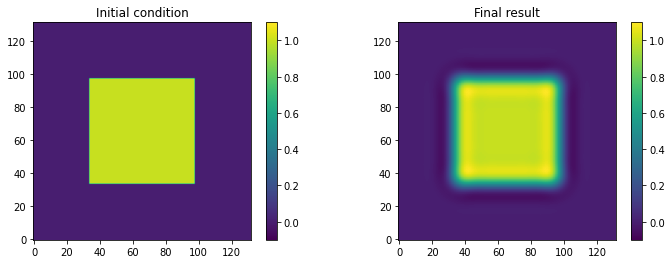

In [69]:
validate_results()

## Parallelization of the K-Loop
Let's use perftools-lite to generate a performance report for the base version. This will be useful to guide our parallelization approach.

In [70]:
%%bash
srun -n 1 ./stencil2d-base.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_base.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


Take a look at the performance report in the file `report_base.txt`. Which are the lines which consume most of the runtime (hot loops)? These code regions should be the primary targets for parallelization with OpenMP.
<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Make a copy of the source code and name it <tt>stencil2d-kparallel.F90/cpp</tt>. Compile it (see cell below) and run it (see cell after that). For the time being, the runtime should be the same as the base version. Insert the following block of code immediately at program start to print out the number of available threads.<br>
<b>Fortran</b><br>
<code>!$omp parallel
!$omp master
write(*,*) '#threads = ', omp_get_num_threads()
!$omp end master
!$omp end parallel
</code>
<b>C++</b><br>
<code>#pragma omp parallel
  {
#pragma omp master
    { std::cout << "#threads = " <<  omp_get_num_threads() << std::endl; }
  }
</code>
Compile and run your code again. How many threads do we have available? Does the number match the number of cores?
<br>
<b>2.</b> Now use OpenMP to parallelize the <tt>k</tt>-loop. Compile the code again and execute it. Quickly check that the results are still ok (using <tt>validate_results()</tt>, see below)<br>
<b>3.</b> What does the plot tell you? What might be the issue?<br>
<b>4.</b> Irrespective of the result, how fast is your code relative to the base version? What would you have expected?<br>
<b>5.</b> Generate a perftools-lite report and check what changed relative to the base version. What are the places that consume most of the runtime now?<br>
<b>6.</b> Rerun for <tt>nz</tt>=1, 24, 25, 48, 64 ,480 and inspect the perftools-lite report for each of these settings. Look at how the relative distribution of runtime changes in table 2. Can you guess what is happening? Why is <tt>nz</tt>=64 not an ideal setting?<br>
</div>

In [71]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=kparallel

# For C++ uncomment these lines
# module load daint-gpu
# module load perftools-lite
# CC stencil2d-kparallel.cpp -fopenmp -o stencil2d-kparallel.x -O3

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-kparallel.o -o stencil2d-kparallel.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-kparallel.x' (lite-samples) ...OK


cp stencil2d-kparallel.x stencil2d.x


In [72]:
%%bash
srun -n 1 ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

 #threads =  24
# threads nx ny ny nz num_iter time
data = np.array( [ \
[   24,  128,  128,   64,    1024,  0.2554877E+00], \
] )


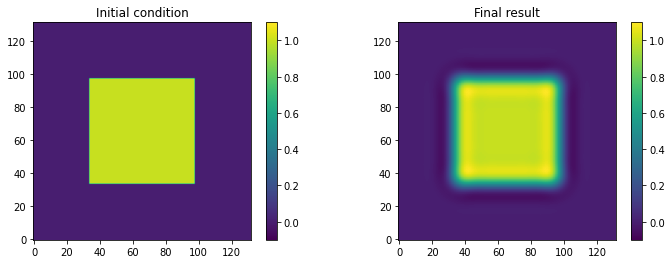

In [73]:
validate_results()

In [83]:
%%bash
srun -n 1 ./stencil2d-kparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_kparallel.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


 ![wrong.png](wrong.png)

 Result looks broken.
 
 
 The problem is that the temporary variable is shared across the loop
 

## Variable Scoping

Inside a parallel region, variables can be either *shared* (all threads see the same copy) or *private* (each thread has its own copy). For now, we have not explicitly declared the scope of variables that are being used in the parallel region. If nothing is specified, the compiler assumes per default that all variables are shared. This is dangerous and can lead to very ugly errors. This is the error you've encountered above.

Some guidelines you can follow to decide the scope of variables are the following:
- Loop indices are private.
- Variables that are used (read or written) solely inside the parallel region are private.
- Variables that are only being read inside the parallel region are shared.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>7.</b> In order to avoid the default behavior, append the <code>default(none)</code> clause on the line with the <code>!$omp parallel do</code>.Recompile (see below). The compiler will now complain that the scope of several variables has not explicitly been specified. For each of these variables, you have to decide whether they are <code>private(var)</code> or <code>shared(var)</code>.<br>
<b>8.</b> Once your code compiles, run it and validate that the results are still looking correct.<br>
<b>9.</b> Move a single variable (e.g. <tt>nx</tt>) from shared to private, recompile, run and visualize the results. Do you understand what happened?<br>
<b>10.</b> Once you are sure that the variable scoping is correct, run one final time and compare the runtime against the previous version and the baseline. Do you understand why we are faster?<br>
</div>

In [76]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=kparallel

# For C++ uncomment these lines
# module load daint-gpu
# module load perftools-lite
# CC stencil2d-kparallel.cpp -fopenmp -o stencil2d-kparallel.x -O3

make: 'stencil2d-kparallel.x' is up to date.


In [77]:
%%bash
srun -n 1 ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

 #threads =  24
# threads nx ny ny nz num_iter time
data = np.array( [ \
[   24,  128,  128,   64,    1024,  0.2585838E+00], \
] )


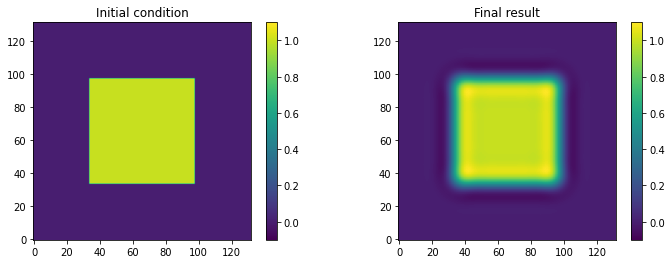

In [78]:
validate_results()

In [81]:
%%bash
srun -n 1 ./stencil2d-kparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_kparallel.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


The compiler complains immediatly if one variable is moved to private

![broken.png](broken.png)

### Performance analysis

Now we are at 0.2585838E+00, compared to sequential 0.8811383E+00 and wrong version 0.4716363E+00.
This is because we are now no longer evicting the cache of other iterations

## Parallelization of the J-Loop
<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>11.</b> Make a copy of the <tt>stencil2d-kparallel.F90/cpp</tt> program and name it <tt>stencil2d-jparallel.F90/cpp</tt>. This time use OpenMP to parallelize the <tt>j</tt>-loop. Make sure to remove the <tt>k</tt>-loop parallelization. Compile it and run it. How fast is your code? What would you have expected?<br>
<b>12.</b> Again generate a report. What changed? Can you use the report to explain your findings above?<br>
    <b>13.</b>  Run you code using just 1 thread (<code>OMP_NUM_THREADS=1</code>). How does the runtime compare against the base version? Run the both versions of the code several times to make sure the result is reproducible. What could be the reason for the difference?<br>
<b>13.</b> Is it a good idea to try and parallelize the <tt>i</tt>-loop? Why?<br>
</div>

In [84]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=jparallel

# For C++ uncomment these lines
# module load daint-gpu
# module load perftools-lite
# CC stencil2d-jparallel.cpp -fopenmp -o stencil2d-jparallel.x -O3

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-jparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-jparallel.o -o stencil2d-jparallel.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-jparallel.x' (lite-samples) ...OK


cp stencil2d-jparallel.x stencil2d.x


In [88]:
%%bash
srun -n 1 ./stencil2d-jparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# threads =           24
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.1529592E+01], \
] )


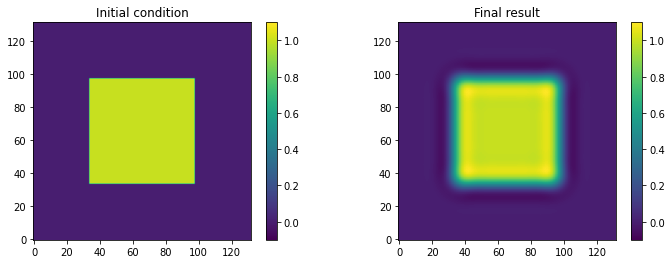

In [87]:
validate_results()

In [89]:
%%bash
srun -n 1 ./stencil2d-jparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_jparallel.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


In [90]:
%%bash
export OMP_NUM_THREADS=1
srun -n 1 ./stencil2d-jparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# threads =            1
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.8811383E+00], \
] )


### Performance analysis

Right now, the performance increases to 0.1529592E+01, significantly slower than the sequential version (0.8811383E+00).

If we look at the profile we see:

```
|  57.8% | 160.0 |   -- |    -- |   -- | ETC
||----------------------------------------------------------------------------
||  45.1% | 125.0 | 36.0 | 57.6% |    2 | fullscan_barrier_list
```

so we see a lot of paralleilzation overhead. This is due to the parallelization being at a different level

This is pretty aligned with what we see in the report:
```
 100.0% | 115.0 |   -- |    -- | Total
|-----------------------------------------------------------------------------
|  91.3% | 105.0 |   -- |    -- | USER
||----------------------------------------------------------------------------
||  40.0% |  46.0 |   -- |    -- | apply_diffusion$main_.LOOP@li.154
3|        |       |      |       |  HPC4WC/day2/solutions/stencil2d-jparallel.F90
||||--------------------------------------------------------------------------
4|||  18.3% |  21.0 |   -- |    -- | line.157
4|||   8.7% |  10.0 |   -- |    -- | line.164
4|||   1.7% |   2.0 |   -- |    -- | line.168
4|||  10.4% |  12.0 |   -- |    -- | line.169
||||==========================================================================
||  40.0% |  46.0 |   -- |    -- | apply_diffusion$main_.LOOP@li.144
3|        |       |      |       |  HPC4WC/day2/solutions/stencil2d-jparallel.F90
||||--------------------------------------------------------------------------
4|||   1.7% |   2.0 |   -- |    -- | line.144
4|||   1.7% |   2.0 |   -- |    -- | line.145
4|||  33.0% |  38.0 |   -- |    -- | line.146
4|||   2.6% |   3.0 |   -- |    -- | line.153
||||==========================================================================
||   9.6% |  11.0 |   -- |    -- | apply_diffusion$main_
3|        |       |      |       |  HPC4WC/day2/solutions/stencil2d-jparallel.F90
4|   8.7% |  10.0 |   -- |    -- |   line.139
||   1.7% |   2.0 |   -- |    -- | apply_diffusion$main_.REGION@li.144
3|        |       |      |       |  HPC4WC/day2/solutions/stencil2d-jparallel.F90
4|        |       |      |       |   line.144
||============================================================================
|   7.8% |   9.0 |   -- |    -- | OMP
||----------------------------------------------------------------------------
||   7.8% |   9.0 |   -- |    -- | apply_diffusion$main_.REGION@li.143(ovhd)
3|        |       |      |       |  HPC4WC/day2/solutions/stencil2d-jparallel.F90
4|        |       |      |       |   line.143
|=============================================================================
```
Where we see the overhead showing up

## Setting the Number of Threads

We now know that we have 12 cores available on the CPU. We want to investigate what the best number of threads is. While it is possible to increase the number of threads beyond the number of cores (in fact the default value we found above is 24, giving 2 threads per core), there probably is an optimum.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>14.</b> Use the <tt>stencil2d-kparallel.F90/cpp</tt> version of the code you developed above and find the optimal number of threads.<br>
<b>15.</b> Do the same thing for the version where you have parallelized the j-loop.
</div>

In [92]:
%%bash
# The file should still be around, but if you need to recompile, here are the steps:

# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=kparallel

# For C++ uncomment these lines
# module load daint-gpu
# CC stencil2d-kparallel.cpp -fopenmp -o stencil2d-kparallel.x -O3

make: 'stencil2d-kparallel.x' is up to date.


In [93]:
%%bash
# The file should still be around, but if you need to recompile, here are the steps:

# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=jparallel

# For C++ uncomment these lines
#module load daint-gpu
#module load perftools-lite
#CC stencil2d-jparallel.cpp -fopenmp -o stencil2d-jparallel.x -O3

make: 'stencil2d-jparallel.x' is up to date.


In [96]:
%%bash
nthreads=1
echo "out = [None] * 21" > out.txt
for nthreads in `seq 1 20` ; do
export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 24 ] ; then
    ncores=24
  fi
  srun -n 1 -c $ncores ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out.txt
done

In [97]:
exec(open("out.txt", "r").read())
labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())

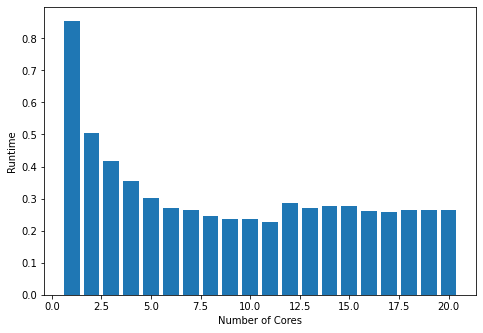

In [100]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Runtime')
plt.show()

In [102]:
%%bash
nthreads=1
echo "out = [None] * 21" > out_j.txt
for nthreads in `seq 1 20` ; do
export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 24 ] ; then
    ncores=24
  fi
  srun -n 1 -c $ncores ./stencil2d-jparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_j.txt
done

In [103]:
exec(open("out_j.txt", "r").read())
labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())

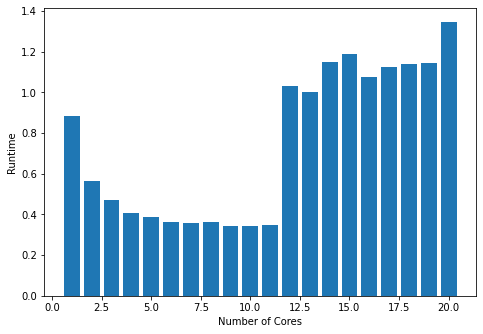

In [104]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Runtime')
plt.show()

<div class="alert alert-block alert-warning">
The concepts presented up to here are key to understanding how to optimize weather and climate codes. The next set of questions should deepen your understanding of OpenMP and shared memory parallelism in general. The following exercises can be considered a bonus if the time is too short.<br>
The questions are split into two sections: Deeper understanding of OpenMP and playing with minor optimizations in the stencil2d example. They can be solved in either order
</div>

# Understanding OpenMP

## Diagnostics of our Field
The first task is to understand how to use critical sections, atomics and proper variable scoping to implement a function that calculates the maximal value present in the 3d field. 
<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
<b>B1.</b> Make a copy of the base source code and name it <tt>stencil2d-max.F90/cpp</tt>.<br>
Add the function that iterates over all fields and reports the highest value found after every 100th iteration. Report the value to the standard output (<code>std::cout</code> or <code>write(*, *)</code>)<br>
<b>B2.</b> Make a copy of the maximum computing code and name it <tt>stencil2d-parallelmax.F90/cpp</tt>.<br>
In it, parallelize the diagnostics. Can you put this into a parallel section or does it need its own? Can you reproduce the same results?
</div>

In [105]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
make VERSION=max

# For C++ uncomment these lines
# module load daint-gpu
# CC stencil2d-max.cpp -fopenmp -o stencil2d-max.x -O3

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-max.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-max.o -o stencil2d-max.x
cp stencil2d-max.x stencil2d.x


In [106]:
%%bash
srun -n 1 ./stencil2d-max.x --nx 128 --ny 128 --nz 64 --num_iter 410

 # 1.09911919
 # 1.09988868
 # 1.09759319
 # 1.10005009
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,     410,  0.3213816E+00], \
] )


In [107]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
make VERSION=parallelmax

# For C++ uncomment these lines
# module load daint-gpu
# CC stencil2d-parallelmax.cpp -fopenmp -o stencil2d-parallelmax.x -O3

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-parallelmax.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-parallelmax.o -o stencil2d-parallelmax.x
cp stencil2d-parallelmax.x stencil2d.x


In [108]:
%%bash
srun -n 1 ./stencil2d-parallelmax.x --nx 128 --ny 128 --nz 64 --num_iter 410

 # 1.09911919
 # 1.09988868
 # 1.09759319
 # 1.10005009
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,     410,  0.3277247E+00], \
] )


## Manual Implementation of the `omp parallel for` Pragma
There is a way to re-implement what a parallel for loop does with the directives `omp parallel`, `omp private`, `omp single`(or similar) and `omp task`. We let the scheduling happen automagically and do not worry about it for now. 
The second task is to write a simple loop that prints the thread number that executes the iteration as well as the iteration number though the full loop. A skeleton code is available in for loop.cpp.
<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
<b>B3.</b> Insert the required pragmas to make sure that more than one thread works on the various pieces of the code
</div>

In [109]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
ftn -h omp -o forloop.x forloop.F90

# For C++ uncomment these lines
#module load daint-gpu
#CC forloop.cpp -fopenmp -o forloop.x

In [110]:
%%bash
srun -n 1 ./forloop.x 10

Thread 3 executed loop iteration 1
Thread 2 executed loop iteration 5
Thread 5 executed loop iteration 8
Thread 6 executed loop iteration 2
Thread 7 executed loop iteration 7
Thread 1 executed loop iteration 10
Thread 4 executed loop iteration 6
Thread 9 executed loop iteration 3
Thread 0 executed loop iteration 9
Thread 8 executed loop iteration 4


# Minor Optimizations of Stencil2D

## Fusing the Computation Loops

Currently we have the computation in two ij loops. Since we know that writing into a 2d field and reading it again might be additional memory overhead, we would ideally have the computation in just one loop.

There is a way to fuse the computational loops (and have the update on a separate loop). 

The code would have the structure of `stencil2d-fusion.F90 / cpp`.

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
<b>B4.</b> Implement the loop bounds and the computation.<br>
<b>B5.</b> Quickly check that the results are still ok (using <tt>validate_results()</tt>, see below)<br>
<b>B6.</b> Use any combination of techniques learned to parallelize this code<br>
<b>B7.</b> Look at the performance in your ideal setting (parallelization with either j or k loop, optimal number of threads)/ How does it compare? How much speedup would you have expected?<br>
    <b>B8.</b> By looking at the perftools-lite report, can you explain the performance?
</div>

In [112]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=fusion

# For C++ uncomment these lines
# module load daint-gpu
# module load perftools-lite
# CC stencil2d-fusion.cpp -fopenmp -o stencil2d-fusion.x -O3

make: 'stencil2d-fusion.x' is up to date.


In [116]:
%%bash
srun -n 1 ./stencil2d-fusion.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.1224886E+01], \
] )


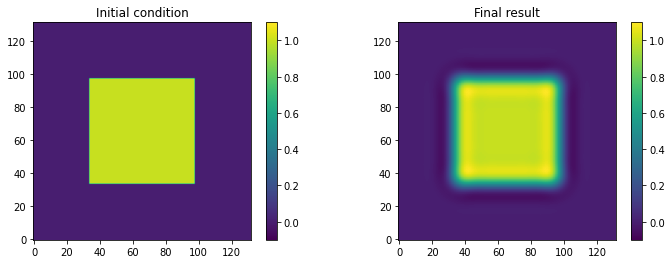

In [114]:
validate_results()

In [115]:
%%bash
srun -n 1 ./stencil2d-fusion.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_inlining.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


## Parallelizing the Halo Update

The halo updates are a set of small loops that are all independent. The amount of work done in there independent loops is significantly smaller than the work in the main loop. We try to investigate how to parallelize them efficiently
<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
<b>B9.</b> By looking at the perftools report of previous runs, can you explain why this was a bonus exercise? What is the expected performance gain of this parallelization? <br>
    <b>B10.</b> Make a copy of the source code and name it <tt>stencil2d-parallel-halo.F90/cpp</tt><br>
<b>B11</b> Implement a parallel version of the halo updates with the learnings from before (which loop to parallelize, what number of threads to use, how to scope the variables)<br>
<b>B12</b> Quickly check that the results are still ok (using <tt>validate_results()</tt>, see below)<br>
<b>B13.</b> By looking at the performance report, can you discuss your predictions? Why were they / were they not matched?<br>    
</div>

In [128]:
%%bash
# For Fortran uncomment these lines
# module load daint-gpu
# module switch PrgEnv-gnu PrgEnv-cray
# module load perftools-lite
# make VERSION=parallel-halo

# For C++ uncomment these lines
module load daint-gpu
module load perftools-lite
CC stencil2d-parallel-halo.cpp -fopenmp -o stencil2d-parallel-halo.x -O3

INFO: creating the PerfTools-instrumented executable 'stencil2d-parallel-halo.x' (lite-samples) ...OK


In [129]:
%%bash
srun -n 1 ./stencil2d-parallel-halo.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[ 24, 128, 128, 64, 1024, 5.82016],
] )


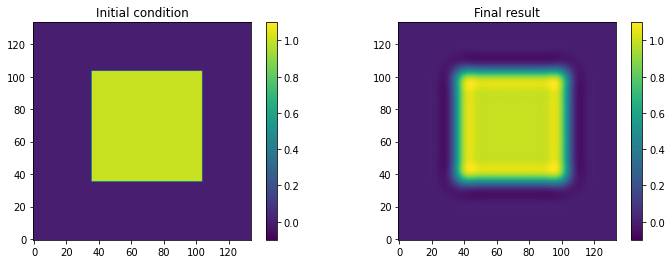

In [130]:
validate_results()

## Exploring the ideal schedule for our program
We know that in a lot of programs, the loop schedule can have a significant impact on the performance. Since weather and climate codes are usually very nicely structured with similar work loads across iterations (excluding boundary layer computation in the vertical), finding the ideal schedule might only lead to small performance gains. We try to nevertheless understand how different schedules behave and what their performance looks like.

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
<b>B14.</b> Modify your code stencil2d-jparallel to test these three loop orders: <br>
<code>static(1)
static(ny/p)
dynamic(1)
</code>
   How does the performance compare? Can you explain what these schedules do?<br>
    <b>B15.</b> What would happen if we did the same experiment on the kparallel version?<br>
<b>B16.</b> Can you think of codes where this is more impactful? Why?
</div>


In [120]:
%%bash
# For Fortran uncomment these lines
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=jparallel

# For C++ uncomment these lines
#module load daint-gpu
#module load perftools-lite
#CC stencil2d-jparallel.cpp -fopenmp -o stencil2d-jparallel.x -O3

make: 'stencil2d-jparallel.x' is up to date.


In [121]:
%%bash
srun -n 1 ./stencil2d-jparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# threads =           24
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.1536710E+01], \
] )


In [131]:
%%bash
make clean

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out*.txt
